In [1]:
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
from instruments import *
from physical_models import *

In [2]:

# Define wavelength bins for CHARIS

wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
2139.4131, 2213.4641, 2290.0781, 2369.3441])

# Loading in past fits from Joost t Hart 2021

offset_imr = -0 # derotator offset
offset_hwp = -0.002 # HWP offset
offset_cal = -0.035 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())



[[ 0.49999981  0.49999944 -0.00061086  0.        ]
 [ 0.49999981  0.49999944 -0.00061086  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


In [4]:
with open(Path('posteriorsummary.txt'),'r') as f:
    mcmc_fits = f.read()
print(mcmc_fits)

{
    "wollaston": {
        "delta_theta": 0.0,
        "theta": 0.0,
        "beam": "o",
        "eta": 1.0,
        "transmission_ratio": 1.0
    },
    "image_rotator": {
        "delta_theta": -0.2759233526806494,
        "theta": 0,
        "wavelength_bin": 15,
        "d": 259.4849704436077
    },
    "hwp": {
        "delta_theta": -2.066991025000643,
        "theta": 0,
        "wavelength_bin": 15,
        "w_SiO2": 1.644620745363353,
        "w_MgF2": 1.284462927774121
    },
    "lp": {
        "delta_theta": -0.7112830555579428,
        "theta": 0.0,
        "epsilon": 1,
        "phi": 0.0
    }
}


In [9]:
def fit_CHARIS_Mueller_matrix_by_bin_phys_model(csv_path, wavelength_bin, new_config_dict_path,plot_path=None):
    """
    Fits a Mueller matrix for one wavelength bin from internal calibration data and saves
    the updated configuratio dictionary to a JSON file. Creates a plot
    of each updated model vs the data. Initial guesses for all fits are from Joost t Hart 2021.
    Note that following the most recent model update these guesses should be updated.
    The csv containing the calibration data and relevant headers can be obtained by 
    the write_fits_info_to_csv function in instruments.py. This code currently fits for
    derotator retardance/offset, HWP retardance/offset, and calibration polarizer offset.
    It can be modified relatively easily to fit for other parameters as well. CURRENT 
    PARAMETERS: IMR retardance, HWP retardance, calibration polarizer diattenuation.

    Parameters
    ----------
    csv_path : str or Path
        Path to the CSV file containing the calibration data. Must contain the columns "D_IMRANG", 
    "RET-ANG1", "single_sum", "norm_single_diff", "diff_std", and "sum_std".

    wavelength_bin : int
        The index of the wavelength bin to fit (0-21 for CHARIS).

    new_system_dict_path : str or Path
        Path to save the new system dictionary as a JSON file. The config dict
        component names will be 'lp' for calibration polarizer, 'image_rotator' for image rotator,
        and 'hwp' for half-wave plate.

    plot_path : str or Path, optional
        Path to save the plot of the observed vs modeled data. If not provided, no plot will be saved.
        Must have a .png extension.
    
    Returns
    -------
    error : np.array
      An array of the errors for each parameter. 
    """
    wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
        1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
        1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
        2139.4131, 2213.4641, 2290.0781, 2369.3441])
    # Check file paths
    filepath = Path(csv_path)
    if not filepath.exists() or filepath.suffix != ".csv":
        raise ValueError("Please provide a valid .csv file.")
    plot_path = Path(plot_path)
    if plot_path.suffix != ".png":
        raise ValueError("Please provide a valid .png file for plotting.")
    if new_config_dict_path.suffix != ".json":
        raise ValueError("Please provide a valid .json file for saving the new system dictionary.")
    new_config_dict_path = Path(new_config_dict_path)
    # Read in data

    interleaved_values, interleaved_stds, configuration_list = read_csv(filepath, mode="physical_model_CHARIS")

    # Loading in past fits 

    offset_imr = -0.2759233526806494 # derotator offset
    offset_hwp = -2.066991025000643 # HWP offset
    offset_cal = -0.7112830555579428 # calibration polarizer offset
    imr_theta = 0 # placeholder 
    hwp_theta = 0 # placeholder
    wsio2 = 1.644620745363353
    wmgf2 = 1.284462927774121
    d = 259.4849704436077
    epsilon_cal = 1 # perfect starting guess

    # Define instrument configuration as system dictionary
    # Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

    system_dict = {
    "components" : {
        "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
        },
        "image_rotator" : {
            "type" : "SCExAO_IMR_function",
            "properties" : {"wavelength":wavelength_bins[wavelength_bin], "d": d, "theta": imr_theta, "delta_theta": offset_imr},
            "tag": "internal",
        },
        "hwp" : {
            "type" : "two_layer_HWP_function",
            "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2": wsio2, "w_MgF2": wmgf2, "theta":hwp_theta, "delta_theta": offset_hwp},
            "tag": "internal",
        },
        "lp" : {  # calibration polarizer for internal calibration source
            "type": "diattenuator_retarder_function",
            "properties": {"epsilon": epsilon_cal, "delta_theta": offset_cal },
            "tag": "internal",
        }}
    }

    # Converting system dictionary into system Mueller Matrix object
    system_mm = generate_system_mueller_matrix(system_dict)

    # Define initial guesses for our parameters 
    # Modify this if you want to change the parameters

    p0 = {
    "lp" : 
        {"epsilon": epsilon_cal},
    }

    # Define some bounds
    # Modify this if you want to change the parameters or minimization bounds
    offset_bounds = (-5,5)
    
    epsilon_cal_bounds = (0.8, 1)
    
    offset_cal_bounds = offset_bounds

    # Minimize the system Mueller matrix using the interleaved values and standard deviations
    # Modify this if you want to change the parameters

    # Counters for iterative fitting

    iteration = 1
    previous_logl = 1000000
    new_logl = 0

    # Perform iterative fitting

    while abs(previous_logl - new_logl) > 0.01*abs(previous_logl):
        if iteration > 1:
            previous_logl = new_logl
        result, new_logl, error = minimize_system_mueller_matrix(p0, system_mm, interleaved_values, 
            interleaved_stds, configuration_list, bounds = [epsilon_cal_bounds],mode='CHARIS')
        print(result)

        # Update p0 with new values

        update_p0(p0, result.x)
        iteration += 1


    # Update p dictionary with the fitted values

    update_p0(p0, result.x)

    # Process model

    p0_values, p0_keywords = parse_configuration(p0)

    # Generate modeled left and right beam intensities

    updated_system_mm = update_system_mm(result.x, p0_keywords, system_mm)

    # Generate modeled left and right beam intensities

    LR_intensities2 = model(p0_values, p0_keywords, updated_system_mm, configuration_list)

    # Process these into interleaved single normalized differences and sums

    diffs_sums2 = process_model(LR_intensities2, 'CHARIS')

    # Plot the modeled and observed values

    plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums2,configuration_list, wavelength= wavelength_bins[wavelength_bin], mode='CHARIS',save_path=plot_path)

    # Print the Mueller matrix

    print("Updated Mueller Matrix:")
    print(updated_system_mm.evaluate())

    # Print residuals

    residuals = interleaved_values[::2] - diffs_sums2[::2]
    print("Residuals range:", residuals.min(), residuals.max())
    print("Error:", error)

    # Save system dictionary to a json file

    with open (new_config_dict_path, 'w') as f:
        json.dump(p0, f, indent=4)
    error = np.array(error)
    return error


In [7]:
offset_imr = -0.2759233526806494 # derotator offset
offset_hwp = -2.066991025000643 # HWP offset
offset_cal = -0.7112830555579428 # calibration polarizer offset
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
wsio2 = 1.644620745363353
wmgf2 = 1.284462927774121
d = 259.4849704436077
epsilon_cal = 1 # perfect starting guess
wavelength_bin = 15
# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
"components" : {
"wollaston" : {
    "type" : "wollaston_prism_function",
    "properties" : {"beam": 'o'}, 
    "tag": "internal",
},
"image_rotator" : {
    "type" : "SCExAO_IMR_function",
    "properties" : {"wavelength":wavelength_bins[wavelength_bin], "d": d, "theta": imr_theta, "delta_theta": offset_imr},
    "tag": "internal",
},
"hwp" : {
    "type" : "two_layer_HWP_function",
    "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2": wsio2, "w_MgF2": wmgf2, "theta":hwp_theta, "delta_theta": offset_hwp},
    "tag": "internal",
},
"lp" : {  # calibration polarizer for internal calibration source
    "type": "diattenuator_retarder_function",
    "properties": {"epsilon": epsilon_cal, "delta_theta": offset_cal },
    "tag": "internal",
}}
}

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.858e+03 -2.001e+03 ... -1.712e+03 -2.775e+03]
           x: [ 9.644e-01]
        cost: 97634448.74509375
         jac: [[-1.570e+04]
               [-1.092e+04]
               ...
               [-9.072e+03]
               [-1.590e+04]]
        grad: [-1.001e+00]
  optimality: 0.035602980123512776
 active_mask: [0]
        nfev: 5
        njev: 5
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-2.858e+03 -2.001e+03 ... -1.712e+03 -2.775e+03]
           x: [ 9.644e-01]
        cost: 97634448.74509375
         jac: [[-1.570e+04]
               [-1.092e+04]
               ...
               [-9.072e+03]
               [-1.590e+04]]
        grad: [-1.001e+00]
  optimality: 0.035602980123512776
 active_mask: [0]
        nfev: 2
        njev: 1


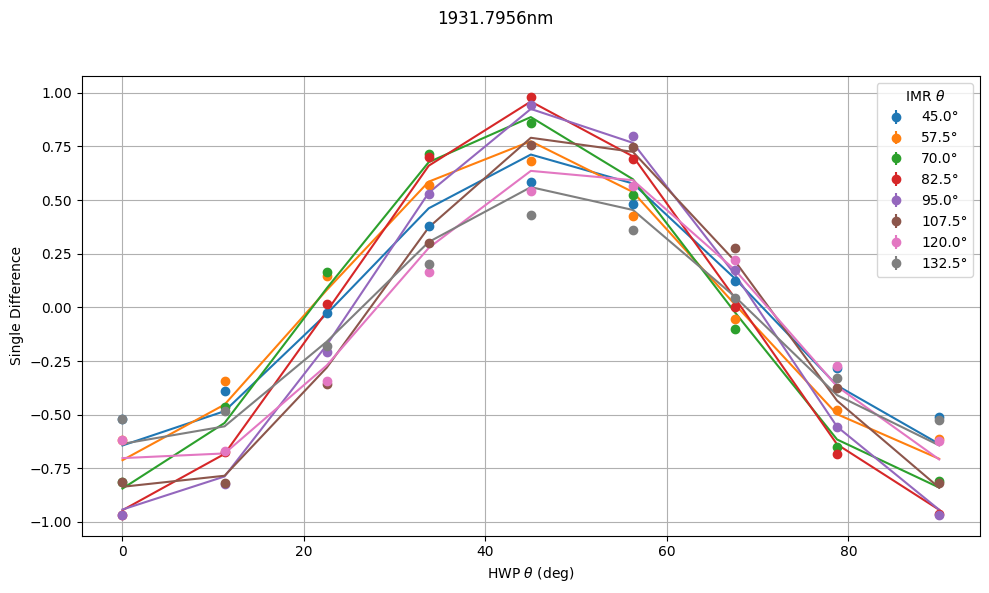

Updated Mueller Matrix:
[[ 0.17832062  0.14873767  0.00065683  0.09836116]
 [-0.17832062 -0.14873767 -0.00065683 -0.09836116]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.130855538258546 0.12367578963167225
Error: [0.00710647]


array([0.00710647])

In [10]:
# Test fitting 
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin15_no_pickoff.csv')
fit_CHARIS_Mueller_matrix_by_bin_phys_model(filepath, 15, 
    Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/system_dicts_no_pickoff_cal/bin15.json'),
    plot_path=Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/model_plots_no_pickoff_cal/bin15.png'),)



     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 4.527e+01  7.405e+01 ...  2.611e+02  1.374e+02]
           x: [ 1.000e+00]
        cost: 6056555.681995012
         jac: [[ 7.698e+02]
               [ 4.387e+02]
               ...
               [ 8.817e+02]
               [ 7.762e+02]]
        grad: [-2.022e+07]
  optimality: 2.244707124896485e-09
 active_mask: [1]
        nfev: 2
        njev: 2
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 4.527e+01  7.405e+01 ...  2.611e+02  1.374e+02]
           x: [ 1.000e+00]
        cost: 6056555.681995012
         jac: [[ 7.698e+02]
               [ 4.387e+02]
               ...
               [ 8.817e+02]
               [ 7.762e+02]]
        grad: [-2.022e+07]
  optimality: 2.244707124896485e-09
 active_mask: [1]
        nfev: 2
        njev: 2


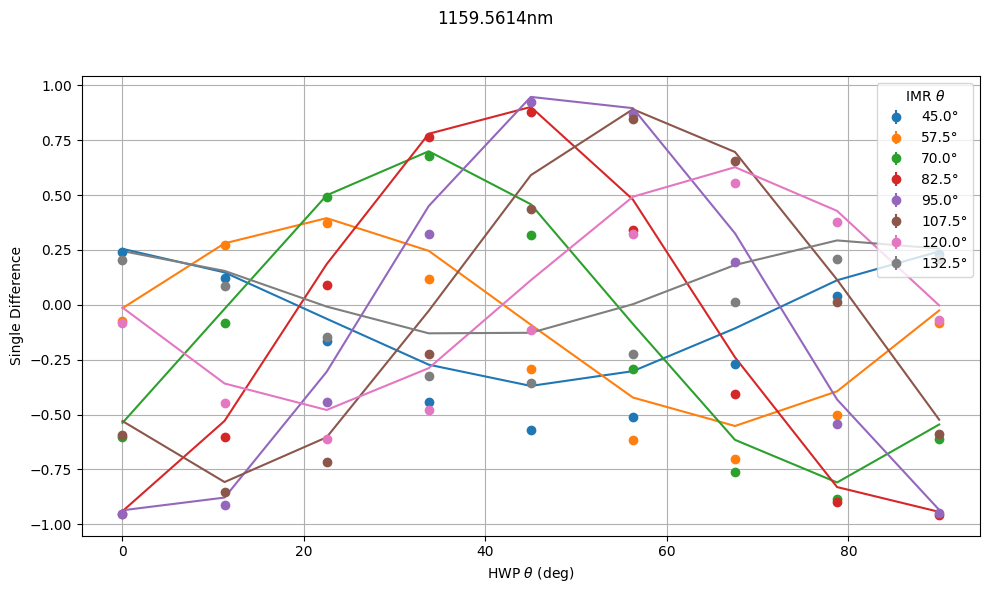

Updated Mueller Matrix:
[[ 6.28289069e-01  6.28095423e-01 -1.55978473e-02 -7.02610432e-09]
 [-6.28289069e-01 -6.28095423e-01  1.55978473e-02  7.02610432e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Residuals range: -0.2301677504169681 -0.007466301051215485
Error: [0.01487747]
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-3.193e+02 -2.724e+02 ... -1.519e+02 -3.506e+02]
           x: [ 1.000e+00]
        cost: 1881585.515755137
         jac: [[ 1.801e+03]
               [ 1.102e+03]
               ...
               [ 1.588e+03]
               [ 1.825e+03]]
        grad: [-1.227e+07]
  optimality: 1.3627895659061123e-09
 active_mask: [1]
        nfev: 2
        njev: 2
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-3.193e+02 -2.724e+02 ... -1.519e+02 -3.506e+02]
           

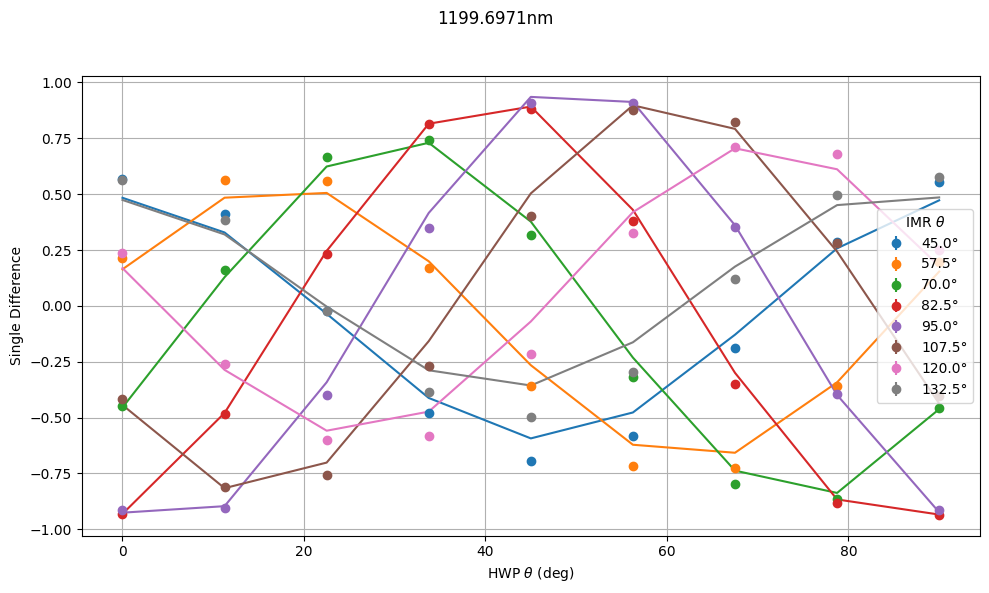

Updated Mueller Matrix:
[[ 7.42734391e-01  7.42505473e-01 -1.84390568e-02 -6.33411280e-09]
 [-7.42734391e-01 -7.42505473e-01  1.84390568e-02  6.33411280e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Residuals range: -0.1445686167557647 0.09327853217899801
Error: [0.0087122]
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-2.772e+00  1.201e+01 ...  6.331e+01 -6.589e+01]
           x: [ 1.000e+00]
        cost: 1359111.5558152024
         jac: [[ 3.619e+03]
               [ 2.134e+03]
               ...
               [ 2.651e+03]
               [ 3.720e+03]]
        grad: [-1.107e+07]
  optimality: 1.228546323225568e-09
 active_mask: [1]
        nfev: 2
        njev: 2
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-2.772e+00  1.201e+01 ...  6.331e+01 -6.589e+01]
           x: 

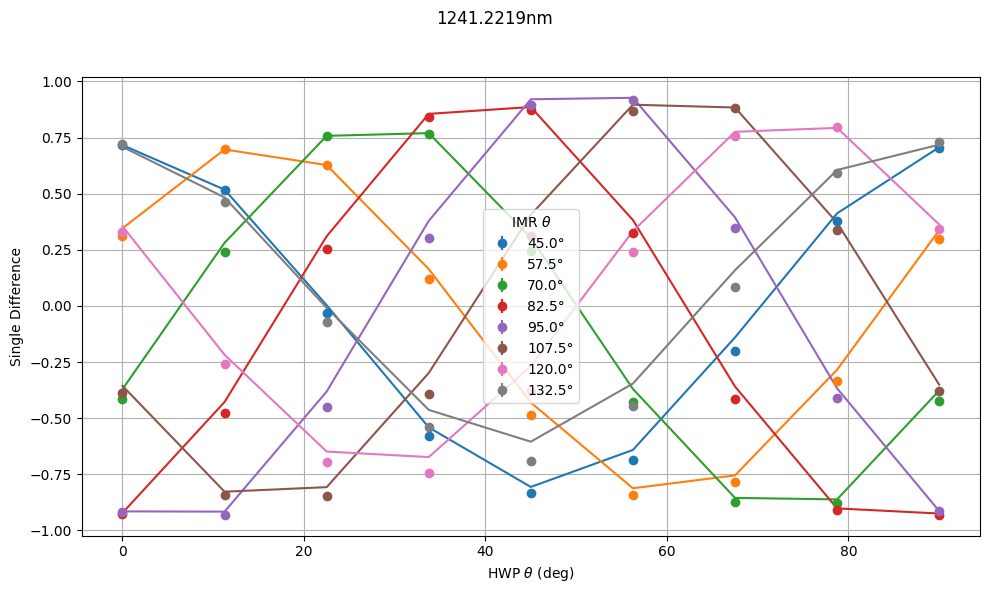

Updated Mueller Matrix:
[[ 8.59198939e-01  8.58934125e-01 -2.13303956e-02 -5.00430074e-09]
 [-8.59198939e-01 -8.58934125e-01  2.13303956e-02  5.00430074e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Residuals range: -0.10860909463809282 0.012722969812793528
Error: [0.00560514]
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.087e+02  1.456e+02 ...  1.912e+02  1.505e+02]
           x: [ 9.849e-01]
        cost: 1754698.0840402276
         jac: [[ 6.941e+03]
               [ 3.455e+03]
               ...
               [ 3.834e+03]
               [ 7.235e+03]]
        grad: [ 4.652e-01]
  optimality: 0.08603546974959814
 active_mask: [0]
        nfev: 5
        njev: 4
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.087e+02  1.456e+02 ...  1.912e+02  1.505e+02]
           x:

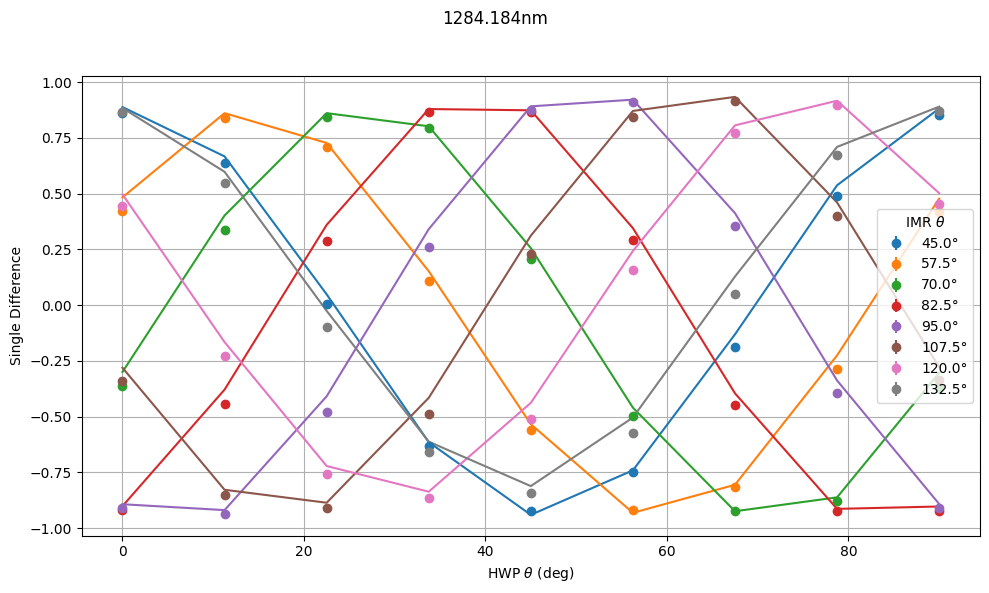

Updated Mueller Matrix:
[[ 0.94502839  0.94431547 -0.01123139 -0.03494021]
 [-0.94502839 -0.94431547  0.01123139  0.03494021]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.08430074627645961 0.017350372003750225
Error: [0.00482608]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 2.634e+02  1.544e+02 ...  2.235e+02  2.998e+02]
           x: [ 9.724e-01]
        cost: 2278543.2675762856
         jac: [[ 1.367e+04]
               [ 5.047e+03]
               ...
               [ 4.940e+03]
               [ 1.368e+04]]
        grad: [ 2.756e-02]
  optimality: 0.004753112019511533
 active_mask: [0]
        nfev: 5
        njev: 5
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.634e+02  1.544e+02 ...  2.235e+02  2.998e+02]
           x: [ 9.724e-01]
        cost: 2278543.2675762856
         jac: [[

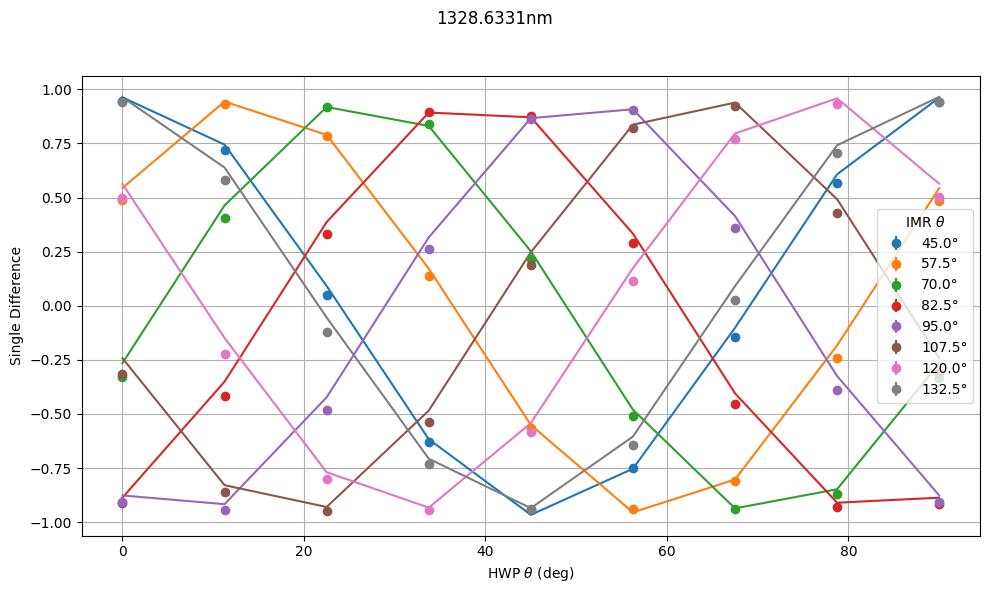

Updated Mueller Matrix:
[[ 0.98253963  0.98239251 -0.0139181  -0.00976597]
 [-0.98253963 -0.98239251  0.0139181   0.00976597]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.07457170723973011 0.02392078323594049
Error: [0.00391097]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 9.269e+02  6.333e+02 ...  8.815e+02  1.300e+03]
           x: [ 9.664e-01]
        cost: 19798004.47293628
         jac: [[ 2.059e+04]
               [ 1.053e+04]
               ...
               [ 9.208e+03]
               [ 1.923e+04]]
        grad: [-1.472e+00]
  optimality: 0.04953072118399986
 active_mask: [0]
        nfev: 5
        njev: 5
     message: Both `ftol` and `xtol` termination conditions are satisfied.
     success: True
      status: 4
         fun: [ 9.269e+02  6.333e+02 ...  8.815e+02  1.300e+03]
           x: [ 9.664e-01]
        cost: 19798004.472936273
 

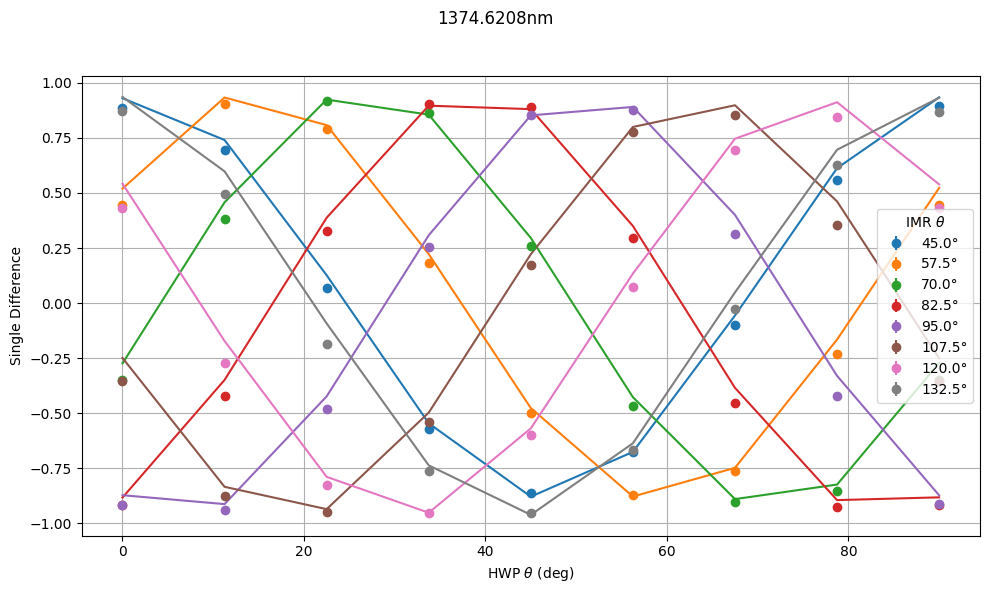

Updated Mueller Matrix:
[[ 0.96613265  0.96534293 -0.01989086  0.03361072]
 [-0.96613265 -0.96534293  0.01989086 -0.03361072]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.1089806146400717 0.01626104046469823
Error: [0.00591046]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 6.578e+02  5.327e+02 ...  7.851e+02  9.910e+02]
           x: [ 9.750e-01]
        cost: 11393399.772455283
         jac: [[ 8.286e+03]
               [ 5.755e+03]
               ...
               [ 4.738e+03]
               [ 7.924e+03]]
        grad: [ 7.510e-01]
  optimality: 0.13141590559108224
 active_mask: [0]
        nfev: 5
        njev: 5
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 6.578e+02  5.327e+02 ...  7.851e+02  9.910e+02]
           x: [ 9.750e-01]
        cost: 11393399.772455283
         jac: [[ 8.

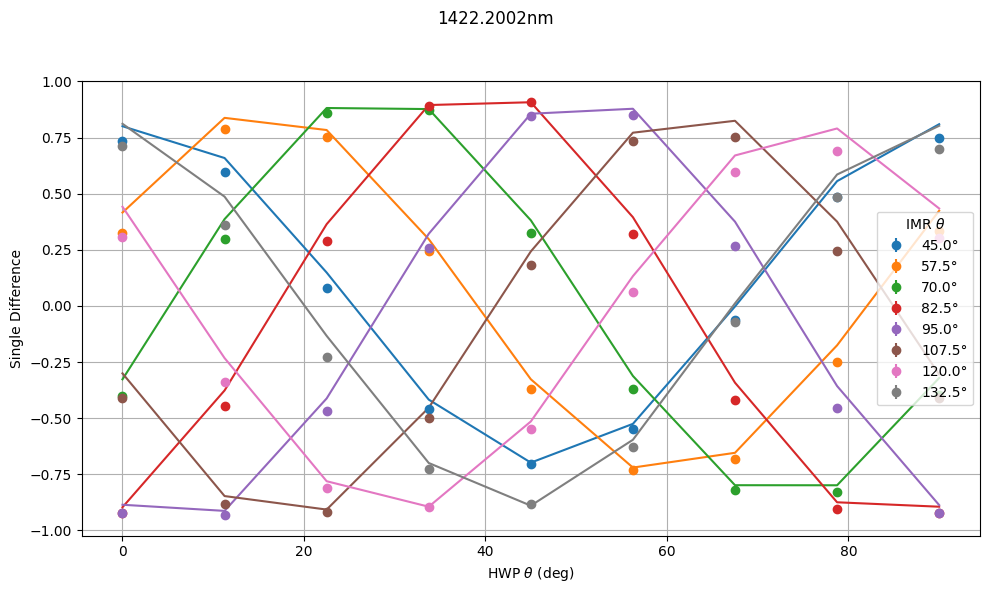

Updated Mueller Matrix:
[[ 0.90134992  0.89880572 -0.02462183  0.06303754]
 [-0.90134992 -0.89880572  0.02462183 -0.06303754]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.13342310175764072 0.006052790158450172
Error: [0.00792807]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 4.664e+02  4.246e+02 ...  6.410e+02  8.075e+02]
           x: [ 9.861e-01]
        cost: 6795990.418052521
         jac: [[ 4.801e+03]
               [ 3.923e+03]
               ...
               [ 3.102e+03]
               [ 4.699e+03]]
        grad: [ 2.945e-01]
  optimality: 0.05479954294644949
 active_mask: [0]
        nfev: 4
        njev: 4
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 4.664e+02  4.246e+02 ...  6.410e+02  8.075e+02]
           x: [ 9.861e-01]
        cost: 6795990.418052521
         jac: [[ 4.

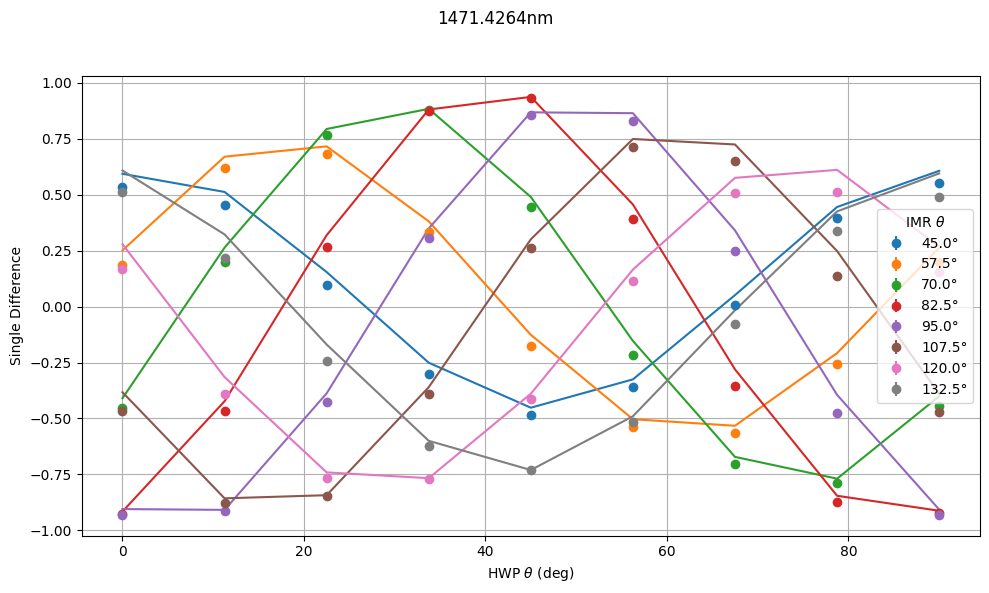

Updated Mueller Matrix:
[[ 0.79769332  0.79457205 -0.02461926  0.06605886]
 [-0.79769332 -0.79457205  0.02461926 -0.06605886]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.11505810981602463 -0.002037201786563747
Error: [0.0071698]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 2.997e+02  3.128e+02 ...  5.285e+02  6.261e+02]
           x: [ 9.936e-01]
        cost: 5863363.856927837
         jac: [[ 2.433e+03]
               [ 2.266e+03]
               ...
               [ 1.660e+03]
               [ 2.423e+03]]
        grad: [ 1.501e-01]
  optimality: 0.029058736780993043
 active_mask: [0]
        nfev: 4
        njev: 4
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.997e+02  3.128e+02 ...  5.285e+02  6.261e+02]
           x: [ 9.936e-01]
        cost: 5863363.856927837
         jac: [[ 2

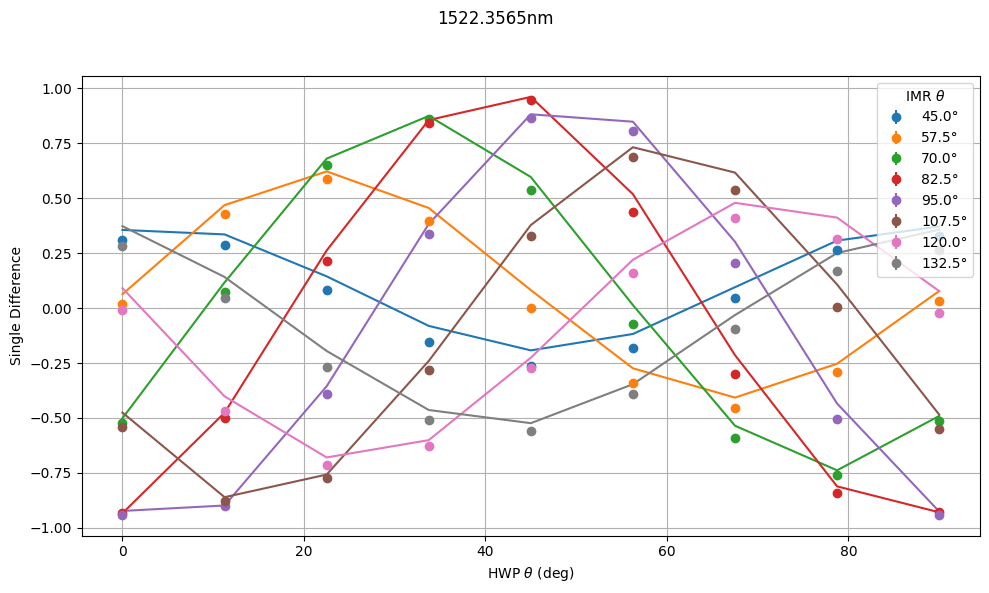

Updated Mueller Matrix:
[[ 0.6785727   0.67621791 -0.02122442  0.05234279]
 [-0.6785727  -0.67621791  0.02122442 -0.05234279]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.10230083892570409 8.597537446519699e-05
Error: [0.00730994]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.117e+01  8.654e+01 ...  3.275e+02  3.209e+02]
           x: [ 9.965e-01]
        cost: 6401458.19666592
         jac: [[ 7.981e+02]
               [ 1.057e+03]
               ...
               [ 5.501e+02]
               [ 8.095e+02]]
        grad: [-1.621e-01]
  optimality: 0.0005751067583830026
 active_mask: [0]
        nfev: 4
        njev: 4
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.117e+01  8.654e+01 ...  3.275e+02  3.209e+02]
           x: [ 9.965e-01]
        cost: 6401458.19666592
         jac: [[ 7

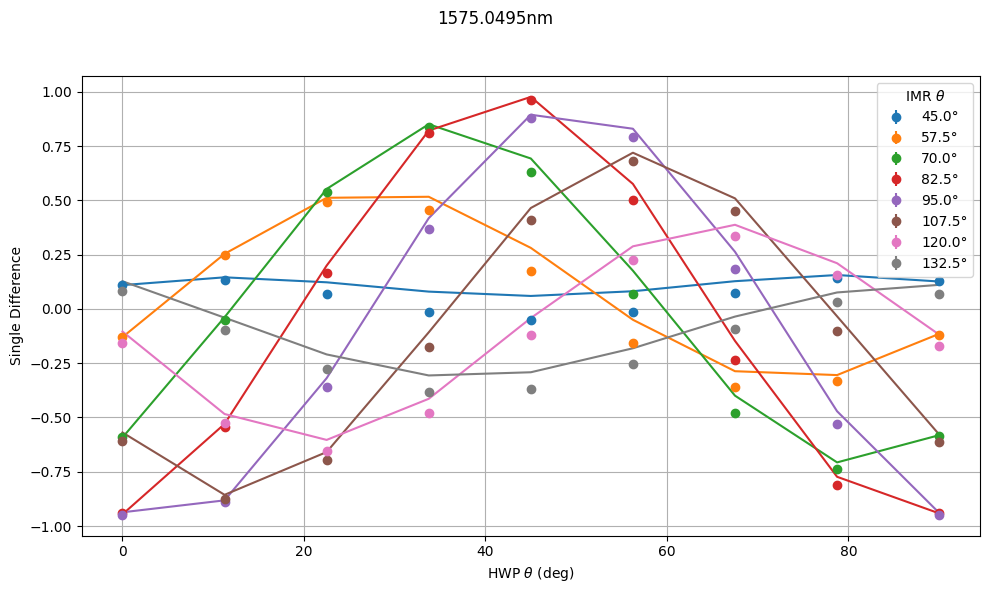

Updated Mueller Matrix:
[[ 0.55535528  0.55352161 -0.0172298   0.04167075]
 [-0.55535528 -0.55352161  0.0172298  -0.04167075]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.11174972200414754 0.00462097711967846
Error: [0.00673899]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.606e+02 -9.657e+01 ...  1.476e+02  7.073e+01]
           x: [ 9.907e-01]
        cost: 6881802.557556996
         jac: [[-9.094e+02]
               [-2.307e+02]
               ...
               [-6.248e+02]
               [-9.113e+02]]
        grad: [-2.974e-02]
  optimality: 0.00027578970051528773
 active_mask: [0]
        nfev: 4
        njev: 4
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-2.606e+02 -9.657e+01 ...  1.476e+02  7.073e+01]
           x: [ 9.907e-01]
        cost: 6881802.557556996
         jac: [[-

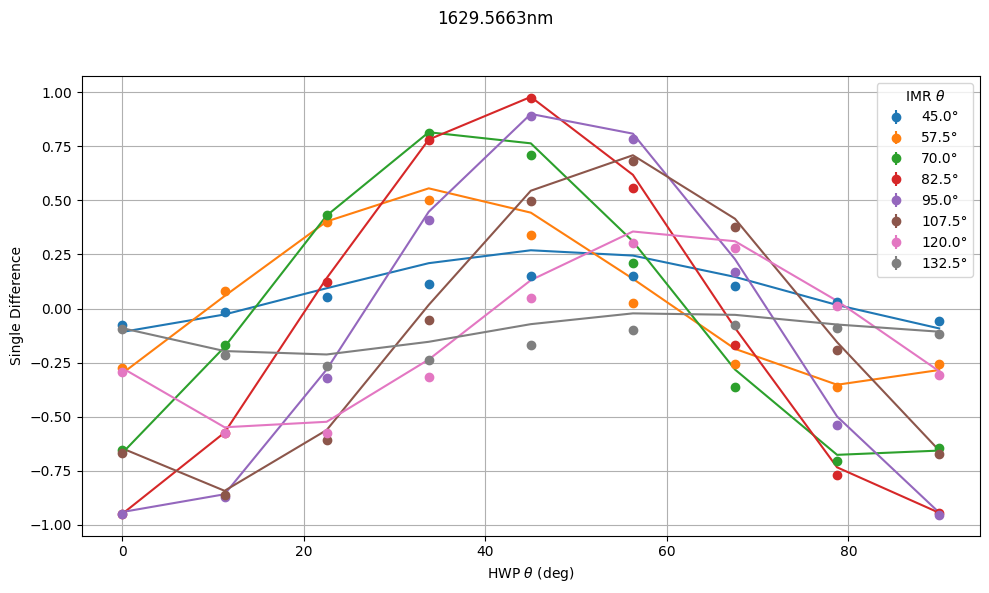

Updated Mueller Matrix:
[[ 0.44634551  0.44094548 -0.01597913  0.06735031]
 [-0.44634551 -0.44094548  0.01597913 -0.06735031]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.11742308906302118 0.036466743476999165
Error: [0.00576131]
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-4.449e+02 -2.276e+02 ... -4.511e-01 -1.665e+02]
           x: [ 9.855e-01]
        cost: 8307586.107330257
         jac: [[-2.485e+03]
               [-1.468e+03]
               ...
               [-1.661e+03]
               [-2.520e+03]]
        grad: [ 1.105e+00]
  optimality: 0.20508510569274474
 active_mask: [0]
        nfev: 5
        njev: 4
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-4.449e+02 -2.276e+02 ... -4.511e-01 -1.665e+02]
           x: [ 9.855e-01]
        cost: 8307586.107330257
         jac: [[-2.

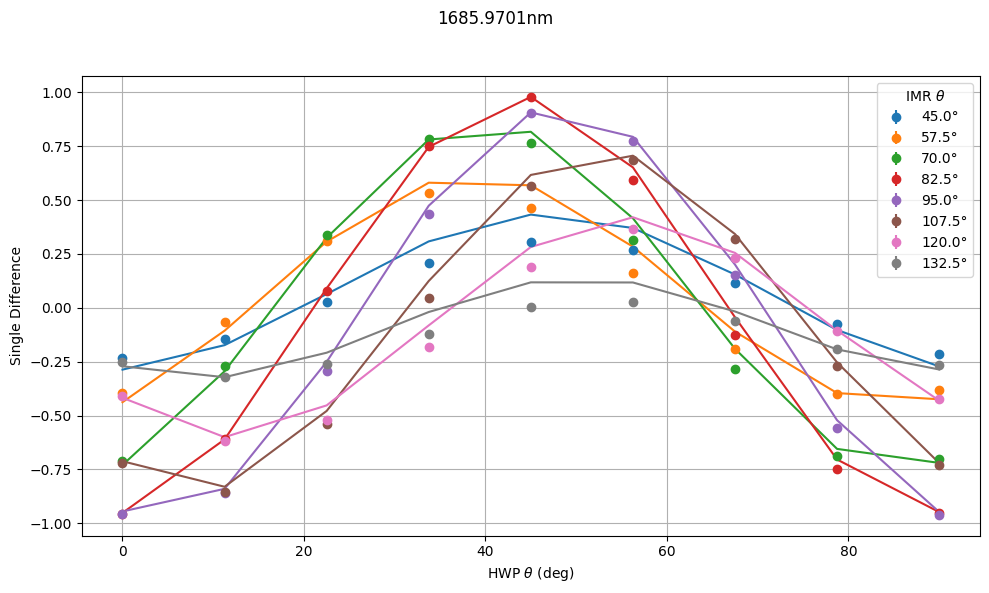

Updated Mueller Matrix:
[[ 0.35692909  0.34737954 -0.01344492  0.08090154]
 [-0.35692909 -0.34737954  0.01344492 -0.08090154]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.1271040220871376 0.05650366825140507
Error: [0.00590698]
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-6.893e+02 -3.895e+02 ... -1.761e+02 -4.638e+02]
           x: [ 9.809e-01]
        cost: 13126682.347981876
         jac: [[-3.929e+03]
               [-2.565e+03]
               ...
               [-2.539e+03]
               [-3.995e+03]]
        grad: [ 1.060e+01]
  optimality: 1.9171706971041957
 active_mask: [0]
        nfev: 5
        njev: 4
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-6.893e+02 -3.895e+02 ... -1.761e+02 -4.638e+02]
           x: [ 9.809e-01]
        cost: 13126682.347981876
         jac: [[-3.9

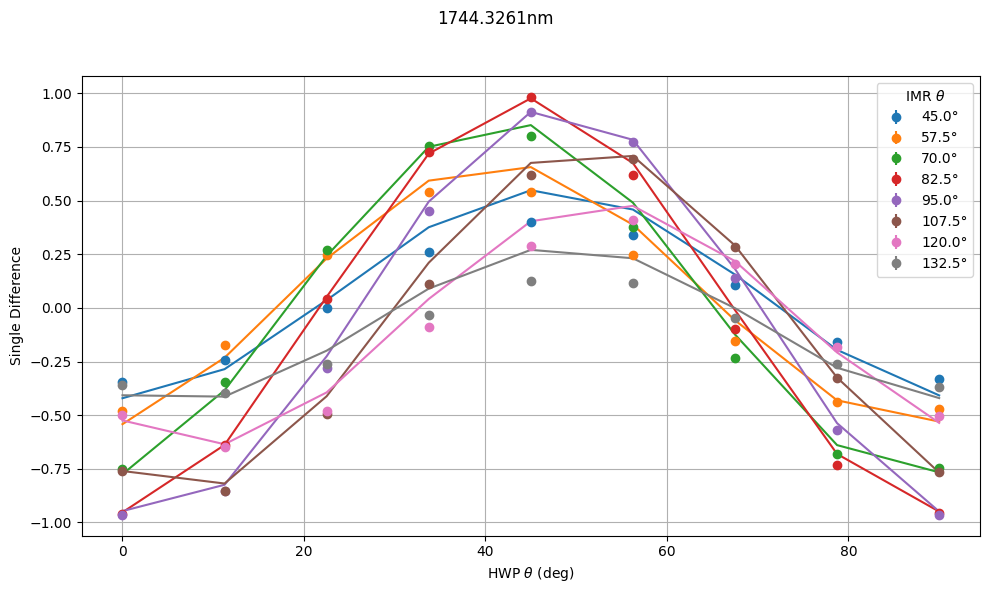

Updated Mueller Matrix:
[[ 0.28979508  0.2759494  -0.01033553  0.08789934]
 [-0.28979508 -0.2759494   0.01033553 -0.08789934]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.14703784800682762 0.07532106227249219
Error: [0.00665518]
     message: Both `ftol` and `xtol` termination conditions are satisfied.
     success: True
      status: 4
         fun: [-1.084e+03 -5.493e+02 ... -2.273e+02 -8.243e+02]
           x: [ 9.760e-01]
        cost: 42552600.456106976
         jac: [[-7.713e+03]
               [-5.192e+03]
               ...
               [-4.783e+03]
               [-7.870e+03]]
        grad: [ 7.475e-01]
  optimality: 0.13153200783961497
 active_mask: [0]
        nfev: 5
        njev: 5
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.084e+03 -5.493e+02 ... -2.273e+02 -8.243e+02]
           x: [ 9.760e-01]
        cost: 42552600.456106976


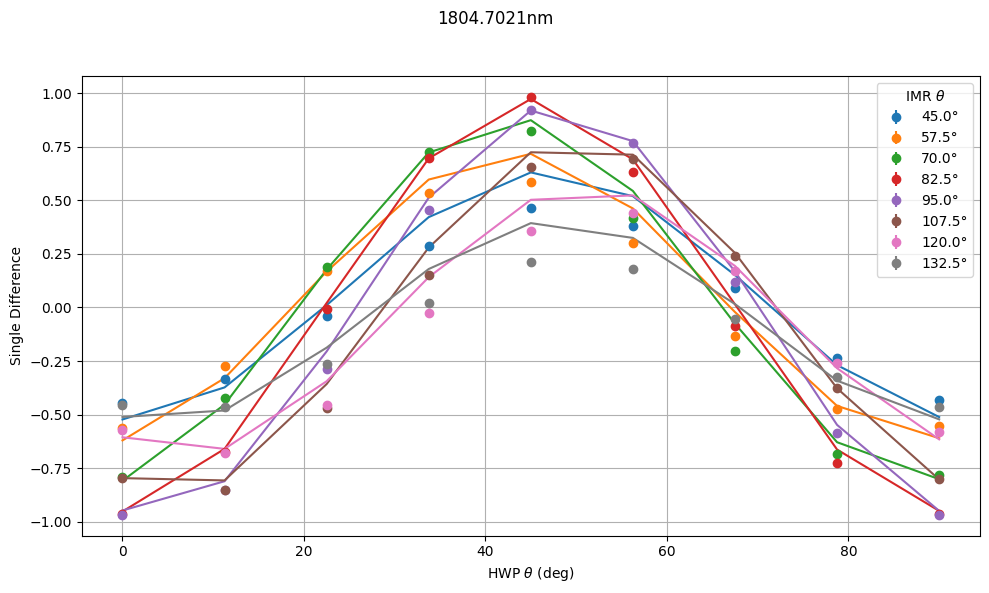

Updated Mueller Matrix:
[[ 0.23892906  0.22037957 -0.0068656   0.09204784]
 [-0.23892906 -0.22037957  0.0068656  -0.09204784]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.17968880301043444 0.0780973873069245
Error: [0.00768857]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-3.027e+03 -1.761e+03 ... -1.249e+03 -2.697e+03]
           x: [ 9.716e-01]
        cost: 189113089.18675888
         jac: [[-2.040e+04]
               [-1.397e+04]
               ...
               [-1.216e+04]
               [-2.077e+04]]
        grad: [-1.041e+01]
  optimality: 0.2958037885772073
 active_mask: [0]
        nfev: 5
        njev: 5
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-3.027e+03 -1.761e+03 ... -1.249e+03 -2.697e+03]
           x: [ 9.716e-01]
        cost: 189113089.18675888
         jac: [[-2.0

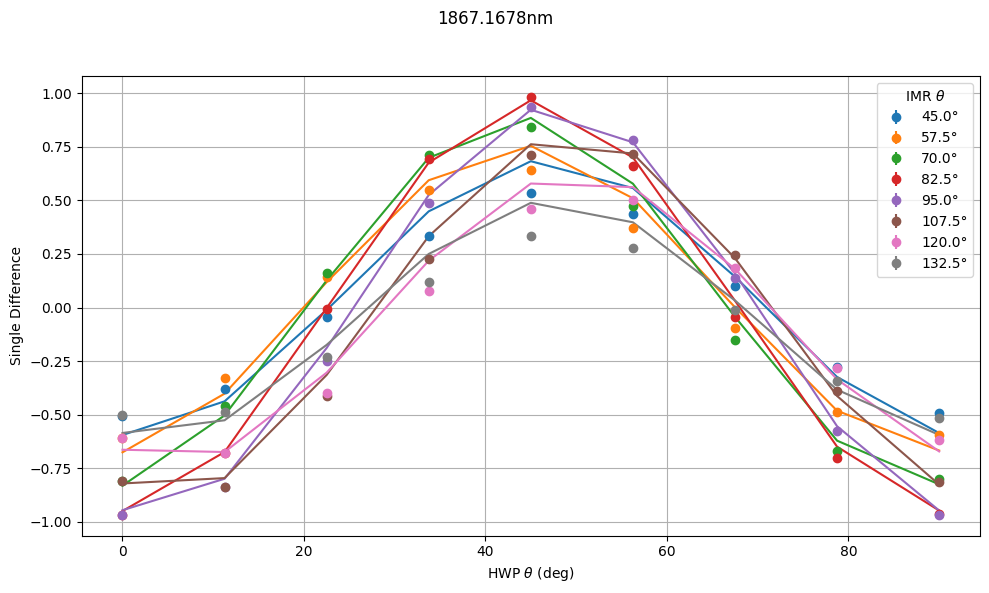

Updated Mueller Matrix:
[[ 0.20246744  0.17952854 -0.00323879  0.09355252]
 [-0.20246744 -0.17952854  0.00323879 -0.09355252]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.15618039015642998 0.0955664566879646
Error: [0.0069541]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.858e+03 -2.001e+03 ... -1.712e+03 -2.775e+03]
           x: [ 9.644e-01]
        cost: 97634448.74509375
         jac: [[-1.570e+04]
               [-1.092e+04]
               ...
               [-9.072e+03]
               [-1.590e+04]]
        grad: [-1.001e+00]
  optimality: 0.035602980123512776
 active_mask: [0]
        nfev: 5
        njev: 5
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-2.858e+03 -2.001e+03 ... -1.712e+03 -2.775e+03]
           x: [ 9.644e-01]
        cost: 97634448.74509375
         jac: [[-1.57

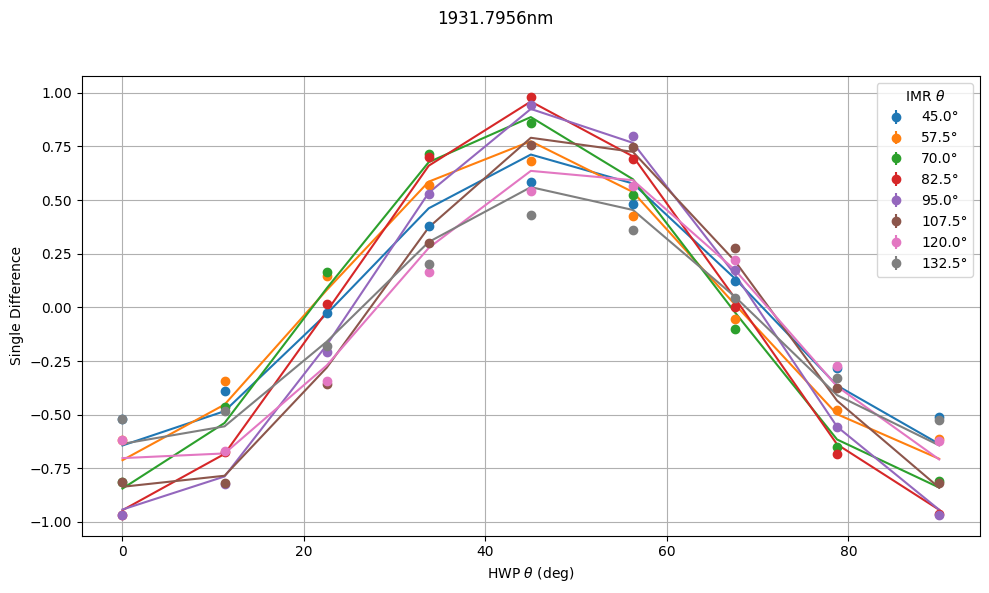

Updated Mueller Matrix:
[[ 0.17832062  0.14873767  0.00065683  0.09836116]
 [-0.17832062 -0.14873767 -0.00065683 -0.09836116]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.130855538258546 0.12367578963167225
Error: [0.00710647]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.569e+03 -1.716e+03 ... -1.520e+03 -2.611e+03]
           x: [ 9.617e-01]
        cost: 88313056.10315022
         jac: [[-1.471e+04]
               [-1.035e+04]
               ...
               [-8.210e+03]
               [-1.483e+04]]
        grad: [-5.623e+00]
  optimality: 0.21545424210565864
 active_mask: [0]
        nfev: 5
        njev: 5
     message: Both `ftol` and `xtol` termination conditions are satisfied.
     success: True
      status: 4
         fun: [-2.569e+03 -1.716e+03 ... -1.520e+03 -2.611e+03]
           x: [ 9.617e-01]
        cost: 88313056.10315013
    

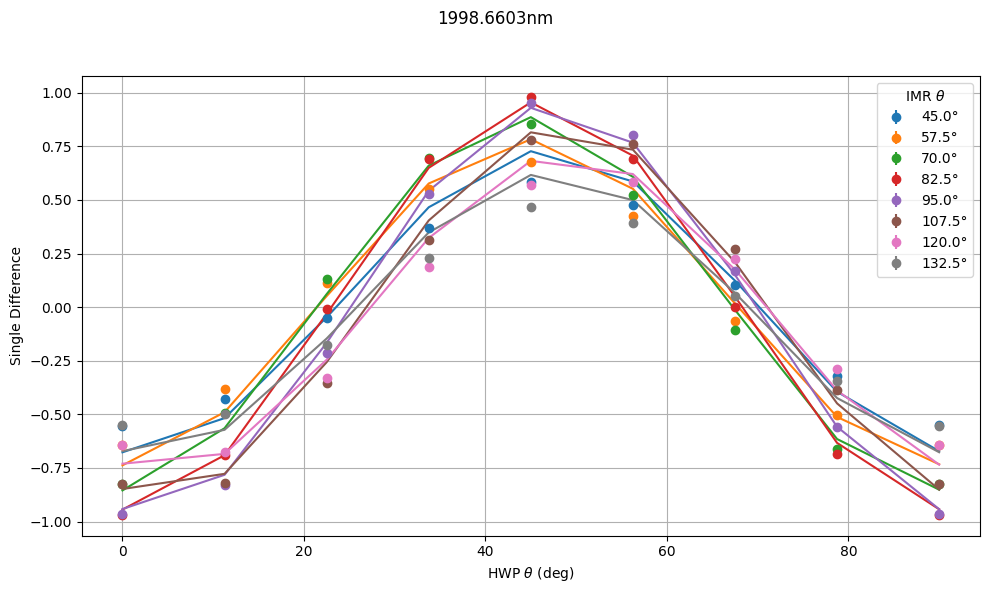

Updated Mueller Matrix:
[[ 0.16170126  0.12921467  0.00434997  0.09711819]
 [-0.16170126 -0.12921467 -0.00434997 -0.09711819]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.14901688458051715 0.12386612661182905
Error: [0.00766558]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.556e+03 -1.757e+03 ... -1.683e+03 -2.713e+03]
           x: [ 9.543e-01]
        cost: 84879769.64010412
         jac: [[-1.430e+04]
               [-1.022e+04]
               ...
               [-7.782e+03]
               [-1.434e+04]]
        grad: [-1.693e+00]
  optimality: 0.07744370662225045
 active_mask: [0]
        nfev: 5
        njev: 5
     message: Both `ftol` and `xtol` termination conditions are satisfied.
     success: True
      status: 4
         fun: [-2.556e+03 -1.757e+03 ... -1.683e+03 -2.713e+03]
           x: [ 9.543e-01]
        cost: 84879769.6401041
   

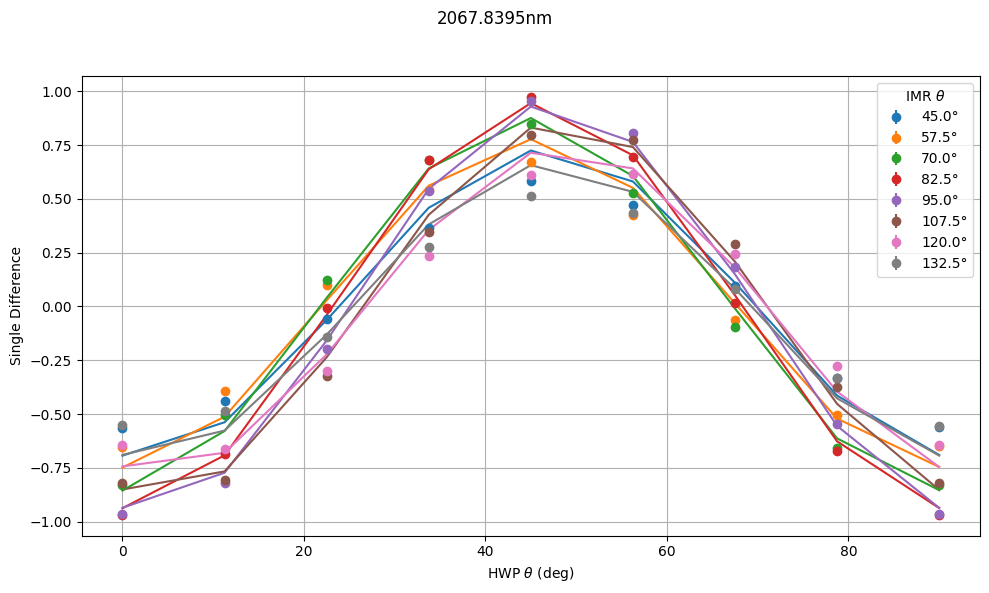

Updated Mueller Matrix:
[[ 0.15356818  0.11434815  0.00876208  0.10213184]
 [-0.15356818 -0.11434815 -0.00876208 -0.10213184]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.1427304085602964 0.1375723795812106
Error: [0.00821694]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.305e+03 -1.594e+03 ... -1.593e+03 -2.537e+03]
           x: [ 9.515e-01]
        cost: 72578757.8689023
         jac: [[-1.292e+04]
               [-9.397e+03]
               ...
               [-6.839e+03]
               [-1.291e+04]]
        grad: [-1.576e-01]
  optimality: 0.00764288628795256
 active_mask: [0]
        nfev: 5
        njev: 5
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-2.305e+03 -1.594e+03 ... -1.593e+03 -2.537e+03]
           x: [ 9.515e-01]
        cost: 72578757.8689023
         jac: [[-1.292e+

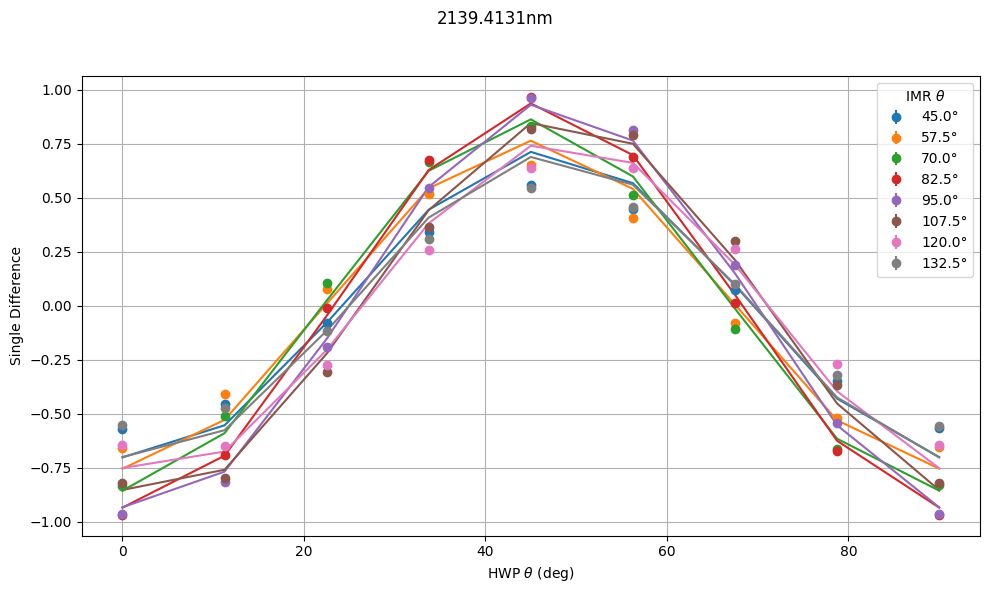

Updated Mueller Matrix:
[[ 0.14902765  0.10725719  0.01290516  0.10265764]
 [-0.14902765 -0.10725719 -0.01290516 -0.10265764]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.15337874743595603 0.14653726265635092
Error: [0.00862005]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.419e+03 -1.827e+03 ... -1.894e+03 -2.703e+03]
           x: [ 9.410e-01]
        cost: 71494548.5683418
         jac: [[-1.149e+04]
               [-8.607e+03]
               ...
               [-6.023e+03]
               [-1.143e+04]]
        grad: [ 9.441e+00]
  optimality: 1.3310818252002234
 active_mask: [0]
        nfev: 5
        njev: 5
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-2.419e+03 -1.827e+03 ... -1.894e+03 -2.703e+03]
           x: [ 9.410e-01]
        cost: 71494548.5683418
         jac: [[-1.149e

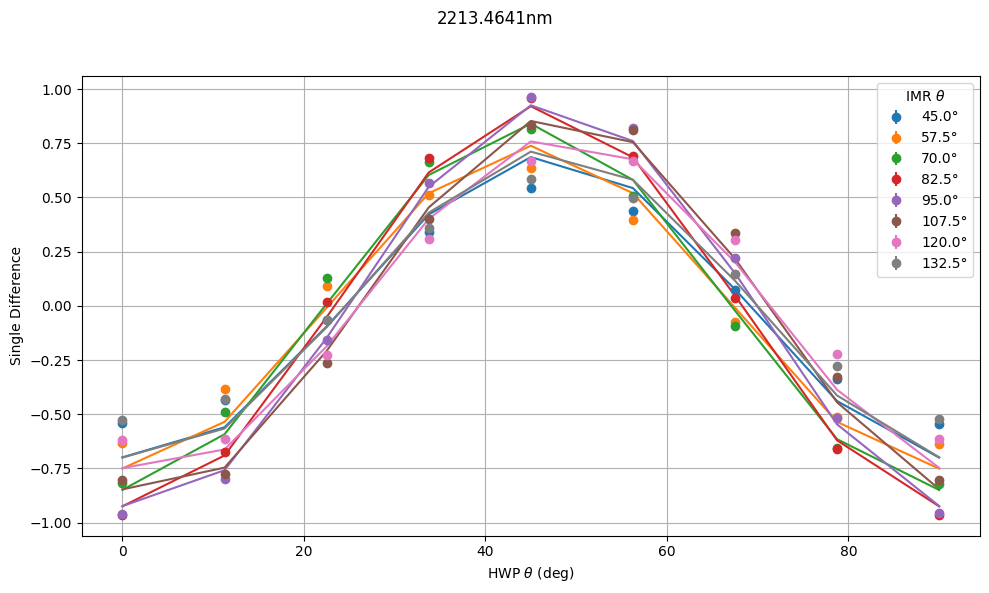

Updated Mueller Matrix:
[[ 0.15076614  0.09985744  0.01901889  0.11134272]
 [-0.15076614 -0.09985744 -0.01901889 -0.11134272]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.1423001498389307 0.17552999748208475
Error: [0.00985592]
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.837e+03 -1.301e+03 ... -1.379e+03 -2.122e+03]
           x: [ 9.349e-01]
        cost: 50209494.24526914
         jac: [[-9.948e+03]
               [-7.639e+03]
               ...
               [-5.033e+03]
               [-9.891e+03]]
        grad: [-2.750e+00]
  optimality: 0.1791189103875961
 active_mask: [0]
        nfev: 6
        njev: 6
     message: Both `ftol` and `xtol` termination conditions are satisfied.
     success: True
      status: 4
         fun: [-1.837e+03 -1.301e+03 ... -1.379e+03 -2.122e+03]
           x: [ 9.349e-01]
        cost: 50209494.24526912
    

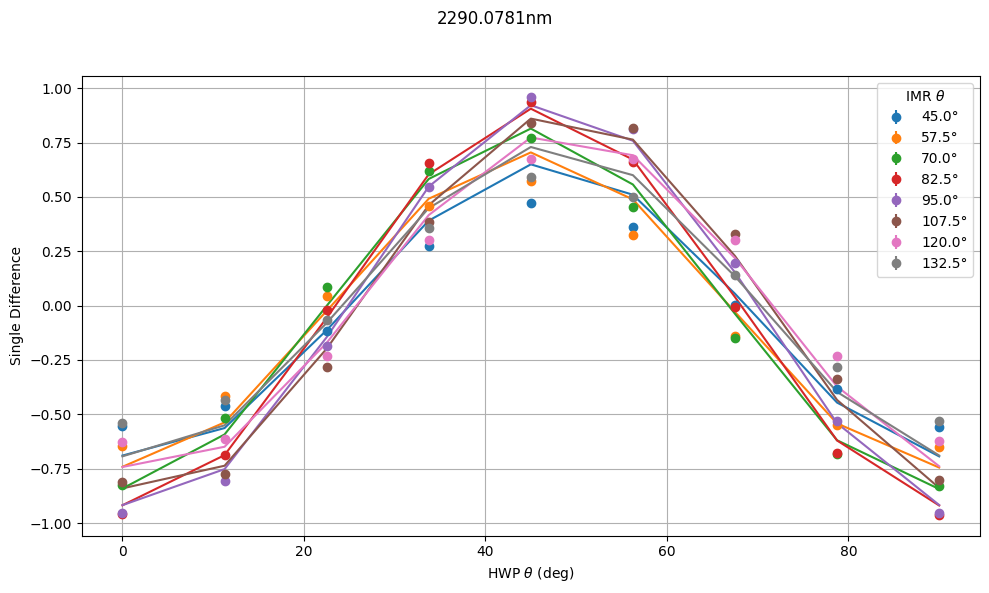

Updated Mueller Matrix:
[[ 0.15535919  0.09944526  0.02523529  0.11666319]
 [-0.15535919 -0.09944526 -0.02523529 -0.11666319]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.1781577968377951 0.1582121059325211
Error: [0.00995951]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.406e+03 -2.057e+03 ... -2.266e+03 -2.687e+03]
           x: [ 9.143e-01]
        cost: 72876374.46326405
         jac: [[-7.445e+03]
               [-6.027e+03]
               ...
               [-3.865e+03]
               [-7.386e+03]]
        grad: [-3.366e+00]
  optimality: 0.2883220484712261
 active_mask: [0]
        nfev: 6
        njev: 6
     message: Both `ftol` and `xtol` termination conditions are satisfied.
     success: True
      status: 4
         fun: [-2.406e+03 -2.057e+03 ... -2.266e+03 -2.687e+03]
           x: [ 9.143e-01]
        cost: 72876374.46326399
     

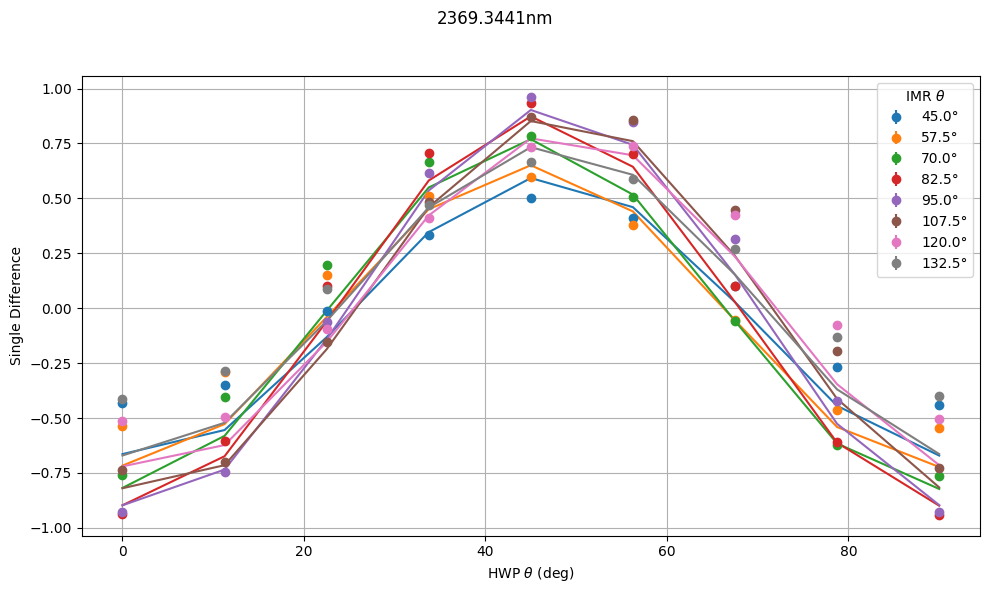

Updated Mueller Matrix:
[[ 0.16806891  0.09506102  0.03602445  0.13383871]
 [-0.16806891 -0.09506102 -0.03602445 -0.13383871]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.08907258513843808 0.2686519957980748
Error: [0.01564344]


In [12]:
# do with all wavelengths

# Fit all 22 wavelength bins
errors = []
for bin in range(0,22):
    error = fit_CHARIS_Mueller_matrix_by_bin_phys_model(
        Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin{bin}_no_pickoff.csv'),
        bin,
        Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/mcmc_params_naive_diattenuation_systemdicts/sysdictbin{bin}nopick.json'),
        plot_path=Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/mcmc_params_naive_diattenuation_model_plots/bin{bin}nopick.png')
    )
    errors.append(error)
